In [1]:
# Cell 1: 기본 import

import os
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms as T
import torchvision.models as models

from pycocotools.coco import COCO

import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Cell 2: 경로 및 device 설정

PROJECT_ROOT = Path("..").resolve()  # 이 ipynb가 notebooks/ 안에 있다고 가정

COCO_DIR = PROJECT_ROOT / "data" / "CarDD_COCO"

ANN_TEST    = COCO_DIR / "annotations" / "instances_test2017.json"
TEST_IMG_DIR = COCO_DIR / "test2017"

INFO_XLSX = COCO_DIR / "annotations" / "image_info.xlsx"

MODELS_DIR = PROJECT_ROOT / "models"
BEST_MODEL_PATH = MODELS_DIR / "visionqc_multitask_resnet34_best.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Cell 3: image_info.xlsx 로드 및 file_name -> location 매핑

df_info = pd.read_excel(INFO_XLSX)

print("image_info columns:", df_info.columns)
print("num rows:", len(df_info))

# file_name / shooting angle 정리
df_info["file_name"] = df_info["file_name"].astype(str)
df_info["shooting angle"] = df_info["shooting angle"].astype(str).str.lower().str.strip()

def map_location_from_angle(angle: str) -> str:
    angle = angle.lower()
    if "front" in angle:
        return "front"
    if "rear" in angle:
        return "rear"
    if "side" in angle:
        return "side"
    return "front"  # 애매하면 front로

df_info["location"] = df_info["shooting angle"].apply(map_location_from_angle)

# 나중에 빠르게 lookup 하기 위해 index=filename
df_info_lookup = df_info.set_index("file_name").to_dict("index")

len(df_info_lookup)

image_info columns: Index(['id', 'file_name', 'width', 'height', 'file_size (KB)', '#instances',
       '#categories', 'shooting angle', 'complete or partial ', 'color'],
      dtype='object')
num rows: 4000


4000

In [4]:
# Cell 4: 라벨 정의 (학습 노트북과 100% 동일해야 함)

# 예시 — 실제로 학습할 때 사용한 정의로 덮어써야 함
DEFECT_LABELS = [
    "dent",
    "scratch",
    "crack",
    "glass_shatter",
    "lamp_broken",
    "tire_flat",
]

SEVERITY_LABELS = ["minor", "moderate", "severe"]

LOCATION_LABELS = ["front", "rear", "side"]

DEFECT2IDX = {name: i for i, name in enumerate(DEFECT_LABELS)}
SEVERITY2IDX = {name: i for i, name in enumerate(SEVERITY_LABELS)}
LOCATION2IDX = {name: i for i, name in enumerate(LOCATION_LABELS)}

print("DEFECT_LABELS:", DEFECT_LABELS)
print("SEVERITY_LABELS:", SEVERITY_LABELS)
print("LOCATION_LABELS:", LOCATION_LABELS)

DEFECT_LABELS: ['dent', 'scratch', 'crack', 'glass_shatter', 'lamp_broken', 'tire_flat']
SEVERITY_LABELS: ['minor', 'moderate', 'severe']
LOCATION_LABELS: ['front', 'rear', 'side']


In [5]:
# Cell 5: COCO + image_info 기반 멀티태스크 라벨 생성 (test용)

def normalize_defect_name(raw_name: str) -> str:
    x = raw_name.lower().strip().replace(" ", "_")
    return x

def map_defect_name(raw_name: str) -> str:
    x = normalize_defect_name(raw_name)
    if x in DEFECT2IDX:
        return x
    # 예외 라벨일 경우 일단 dent로
    return "dent"

def map_severity_using_metadata(instances: int, complete_partial: str) -> str:
    cp = str(complete_partial).strip().lower()

    if cp == "complete":
        return "severe"

    if instances >= 4:
        return "severe"
    elif instances >= 2:
        return "moderate"
    elif instances == 1:
        return "minor"
    else:
        return "minor"

def load_coco_multitask_items(ann_path: Path, img_dir: Path):
    coco = COCO(str(ann_path))
    items = []

    img_ids = coco.getImgIds()
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info["file_name"]

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        if len(anns) == 0:
            continue

        first_ann = anns[0]
        cat_id = first_ann["category_id"]
        cat_info = coco.loadCats([cat_id])[0]
        raw_name = cat_info["name"]

        defect_name = map_defect_name(raw_name)

        info_row = df_info_lookup.get(file_name, None)
        if info_row is not None:
            instances = int(info_row["#instances"])
            complete_partial = info_row["complete or partial "]
            location_name = info_row["location"]
        else:
            instances = 1
            complete_partial = "partial"
            location_name = "front"

        severity_name = map_severity_using_metadata(instances, complete_partial)

        item = {
            "file_name": file_name,
            "filepath": str(img_dir / file_name),
            "defect":   DEFECT2IDX[defect_name],
            "severity": SEVERITY2IDX[severity_name],
            "location": LOCATION2IDX[location_name],
        }
        items.append(item)

    return items

test_items = load_coco_multitask_items(ANN_TEST, TEST_IMG_DIR)
len(test_items)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


374

In [6]:
# Cell 6: Dataset, Transform, DataLoader (Test용)

IMG_SIZE = 224

test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

class CarDamageMultiTaskDataset(Dataset):
    def __init__(self, items, transform=None):
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        img = Image.open(it["filepath"]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        y_def = it["defect"]
        y_sev = it["severity"]
        y_loc = it["location"]

        return img, y_def, y_sev, y_loc

test_dataset = CarDamageMultiTaskDataset(test_items, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

len(test_loader)


6

In [7]:
# Cell 7: 모델 정의 + best pth 로드

class VisionQCMultiTaskResNet34(nn.Module):
    def __init__(self,
                 num_defect: int,
                 num_severity: int,
                 num_location: int,
                 pretrained: bool = True):
        super().__init__()
        backbone = models.resnet34(
            weights=models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        )
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone

        self.fc_defect   = nn.Linear(in_features, num_defect)
        self.fc_severity = nn.Linear(in_features, num_severity)
        self.fc_location = nn.Linear(in_features, num_location)

    def forward(self, x):
        feat = self.backbone(x)
        logits_defect   = self.fc_defect(feat)
        logits_severity = self.fc_severity(feat)
        logits_location = self.fc_location(feat)

        return {
            "defect_type": logits_defect,
            "severity": logits_severity,
            "location": logits_location,
        }

best_model = VisionQCMultiTaskResNet34(
    num_defect=len(DEFECT_LABELS),
    num_severity=len(SEVERITY_LABELS),
    num_location=len(LOCATION_LABELS),
    pretrained=False,  # weight만 로드
).to(device)

state_dict = torch.load(BEST_MODEL_PATH, map_location=device)
best_model.load_state_dict(state_dict)
best_model.eval()

print("Loaded best model from:", BEST_MODEL_PATH)

Loaded best model from: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth


In [8]:
# Cell 8: 평가 함수 및 Test Set 성능 계산

criterion = nn.CrossEntropyLoss()

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct_def = correct_sev = correct_loc = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Eval (Test)", leave=False)
        for imgs, y_def, y_sev, y_loc in pbar:
            imgs = imgs.to(device)
            y_def = y_def.to(device)
            y_sev = y_sev.to(device)
            y_loc = y_loc.to(device)

            out = model(imgs)

            loss_def = criterion(out["defect_type"], y_def)
            loss_sev = criterion(out["severity"],    y_sev)
            loss_loc = criterion(out["location"],    y_loc)
            loss = 1.0 * loss_def + 0.7 * loss_sev + 0.7 * loss_loc

            total_loss += loss.item() * imgs.size(0)

            pred_def = out["defect_type"].argmax(dim=1)
            pred_sev = out["severity"].argmax(dim=1)
            pred_loc = out["location"].argmax(dim=1)

            correct_def += (pred_def == y_def).sum().item()
            correct_sev += (pred_sev == y_sev).sum().item()
            correct_loc += (pred_loc == y_loc).sum().item()
            total += imgs.size(0)

    avg_loss = total_loss / total
    acc_def = correct_def / total
    acc_sev = correct_sev / total
    acc_loc = correct_loc / total

    return avg_loss, acc_def, acc_sev, acc_loc

test_loss, acc_def_t, acc_sev_t, acc_loc_t = evaluate(best_model, test_loader, device)

print("\n[Best Model] Evaluation on TEST Set")
print(f"  test_loss={test_loss:.4f}")
print(f"  defect_acc={acc_def_t:.3f}")
print(f"  severity_acc={acc_sev_t:.3f}")
print(f"  location_acc={acc_loc_t:.3f}")


[Best Model] Evaluation on TEST Set
  test_loss=1.6143
  defect_acc=0.781
  severity_acc=0.604
  location_acc=0.826


DEFECT_LABELS: ['dent', 'scratch', 'crack', 'glass_shatter', 'lamp_broken', 'tire_flat']
SEVERITY_LABELS: ['minor', 'moderate', 'severe']
LOCATION_LABELS: ['front', 'rear', 'side']


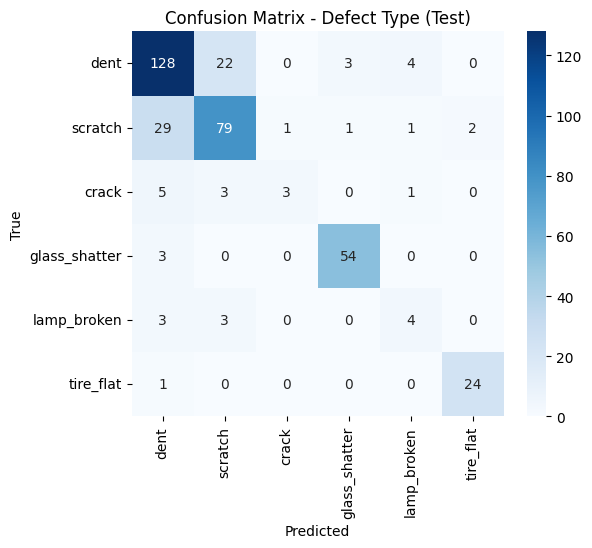

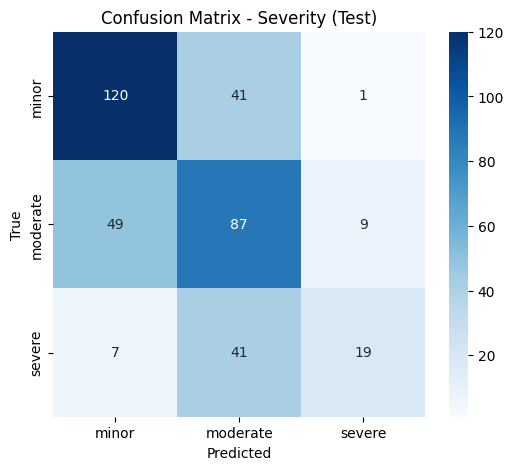

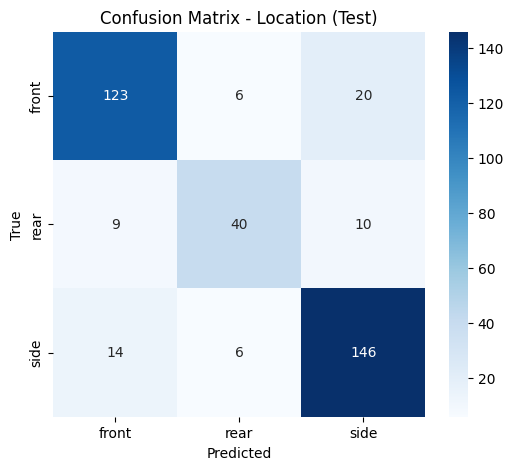


[Defect] Classification report (Test)
               precision    recall  f1-score   support

         dent       0.76      0.82      0.79       157
      scratch       0.74      0.70      0.72       113
        crack       0.75      0.25      0.38        12
glass_shatter       0.93      0.95      0.94        57
  lamp_broken       0.40      0.40      0.40        10
    tire_flat       0.92      0.96      0.94        25

     accuracy                           0.78       374
    macro avg       0.75      0.68      0.69       374
 weighted avg       0.78      0.78      0.78       374


[Severity] Classification report (Test)
              precision    recall  f1-score   support

       minor       0.68      0.74      0.71       162
    moderate       0.51      0.60      0.55       145
      severe       0.66      0.28      0.40        67

    accuracy                           0.60       374
   macro avg       0.62      0.54      0.55       374
weighted avg       0.61      0.60      0.

In [9]:
# Cell 9: Confusion Matrix & Classification Report (Test Set)

all_true_def = []
all_pred_def = []

all_true_sev = []
all_pred_sev = []

all_true_loc = []
all_pred_loc = []

best_model.eval()
with torch.no_grad():
    for imgs, y_def, y_sev, y_loc in test_loader:
        imgs = imgs.to(device)

        out = best_model(imgs)

        pred_def = out["defect_type"].argmax(dim=1).cpu().numpy()
        pred_sev = out["severity"].argmax(dim=1).cpu().numpy()
        pred_loc = out["location"].argmax(dim=1).cpu().numpy()

        all_pred_def.extend(pred_def)
        all_pred_sev.extend(pred_sev)
        all_pred_loc.extend(pred_loc)

        all_true_def.extend(y_def.numpy())
        all_true_sev.extend(y_sev.numpy())
        all_true_loc.extend(y_loc.numpy())

# Confusion matrices
cm_def = confusion_matrix(all_true_def, all_pred_def)
cm_sev = confusion_matrix(all_true_sev, all_pred_sev)
cm_loc = confusion_matrix(all_true_loc, all_pred_loc)

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

print("DEFECT_LABELS:", DEFECT_LABELS)
print("SEVERITY_LABELS:", SEVERITY_LABELS)
print("LOCATION_LABELS:", LOCATION_LABELS)

plot_confusion_matrix(cm_def, DEFECT_LABELS, "Confusion Matrix - Defect Type (Test)")
plot_confusion_matrix(cm_sev, SEVERITY_LABELS, "Confusion Matrix - Severity (Test)")
plot_confusion_matrix(cm_loc, LOCATION_LABELS, "Confusion Matrix - Location (Test)")

# Classification report (원하면 task별 출력)
print("\n[Defect] Classification report (Test)")
print(classification_report(all_true_def, all_pred_def, target_names=DEFECT_LABELS))

print("\n[Severity] Classification report (Test)")
print(classification_report(all_true_sev, all_pred_sev, target_names=SEVERITY_LABELS))

print("\n[Location] Classification report (Test)")
print(classification_report(all_true_loc, all_pred_loc, target_names=LOCATION_LABELS))